chisquared / ndf : 11.379539978576775 / 19 = 0.5989231567671987
Fitted data signal: 287.08023498931277
Fitted data signal error: 107.20080011016519
Cross Section: 78.07494129461983
Statistical Error: 29.154553867663527
 FCN=11.3795 FROM HESSE     STATUS=FAILED         19 CALLS         458 TOTAL
                     EDM=3.0626e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY 100.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.97017e+04   9.07059e+00   4.27731e-02  -1.44931e-08
   2  p1          -1.68554e+00   6.41436e-05   8.03727e-07   3.81417e-05
   3  p2           1.09619e-05   4.43471e-10   5.22706e-12   8.00578e+01
   4  p3          -2.43367e-11   3.01620e-15   1.16046e-17  -1.50400e+07
   5  p4          -9.95170e+04   1.79061e-16   1.79061e-18   1.01403e+16
   6  p5           1.00000e-20   1.41421e+00   1.41421e-02   1.02729e+00
 FCN=13.5543 FROM HESSE     ST

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Final
Error in <TF1Helper::IntegralError>: Last used fitter is not compatible with the current TF1


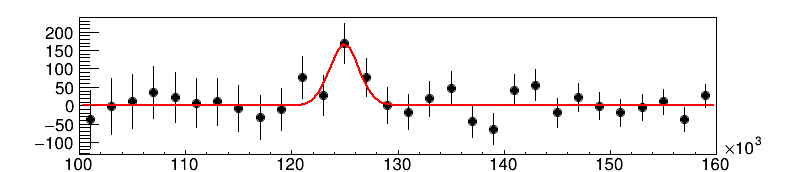

In [2]:
import ROOT as r
from FitFunctions import *
import ctypes
from ctypes import c_double
from PlotSetting import *

canvas = r.TCanvas("Final")

f_invMass = r.TFile("out/Final_combinations/DATA_final_8.root", "READ")
invMass = f_invMass.Get("invMass")
invMass.SetDirectory(0)
f_invMass.Close()

invMass_0 = invMass.Clone("Copy of original data")
invMass_bkg = invMass.Clone("Background fit") 
invMass_sub = invMass.Clone("To be subtracted")

quartic = r.TF1("quartic_bkg", quartic_bkg, 100e3, 160e3, 4)
quartic.SetParameters(-6.26e2, 6.29e-5, -1.49e-10, -2.65e-15)

cubic = r.TF1("cubic_bkg", cubic_bkg, 100e3, 160e3, 5)
cubic.SetParameters(-1.07093e+05, 3.62486e+00, -4.32249e-05, 2.22406e-10, -4.22052e-16)

quintic = r.TF1("quintic_bkg", quintic_bkg, 100e3, 160e3, 6)
quintic.SetParameters(-1.07093e+05, 3.62486e+00, -4.32249e-05, 2.22406e-10, -4.22052e-16, 1e-20)

sextic = r.TF1("sextic_bkg", sextic_bkg, 100e3, 160e3, 7)
sextic.SetParameters(-1.07093e+04, 3.62486e+00, -4.32249e-05, 2.22406e-10, -4.22052e-16, 1e-22, 1e-25)

expPoly2 = r.TF1("expPoly2_bkg", expPoly2_bkg, 100e3, 160e3, 3)
expPoly2.SetParameters(5e4, 1e-10, 1e-10)

expPoly3 = r.TF1("expPoly3_bkg", expPoly3_bkg, 100e3, 160e3, 4)
expPoly3.SetParameters(1e5, 1e-16, 1e-16, 1e-16)

expPoly4 = r.TF1("expPoly4_bkg", expPoly4_bkg, 100e3, 160e3, 5)
expPoly4.SetParameters(5e4, -2e-5, 2e-12, -9e-19, 1e-24)

fit_func_str = "cubic_bkg"
fit_result_bkg = invMass_bkg.Fit(fit_func_str, "M, S")
fitted_bkg = invMass_bkg.GetFunction(fit_func_str)

# Reset errors
original_errors = []
for i in range(invMass.GetNbinsX()):
    original_errors = original_errors + [invMass.GetBinError(i + 1)]

for i in range(invMass.GetNbinsX()):
    invMass_sub.AddBinContent(i+1, -1 * (fitted_bkg(invMass_sub.GetBinCenter(i+1))))
    invMass_sub.SetBinError(i+1, original_errors[i])

GAUS_FIT = True
if (GAUS_FIT):
    gaus1 = r.TF1("gaus1", gaus_1, 100e3, 160e3, 3)
    gaus1.SetParameters(1, 125e3, 5e4)
    gaus1.FixParameter(1, 125e3)
    
    # print(invMass_gaus.GetBinContent(13))
    # invMass_gaus.SetBinError(12, 0)

    invMass_sub.Fit("gaus1", "M, S, B, R")
    fitted_gaus = invMass_sub.GetFunction("gaus1")

    fitted_gaus.SetLineColorAlpha(2, 0.8)

chisquared = fit_result_bkg.MinFcnValue()   
ndf = fit_result_bkg.Ndf()

N_fit_sig = fitted_gaus.Integral(120e3, 130e3) / 2e3
N_fit_sig_err = fitted_gaus.IntegralError(120e3, 130e3) / 2e3

N_bkg = fitted_bkg.Integral(120e3, 130e3) / 2e3
N_bkg_err = fitted_bkg.IntegralError(120e3, 130e3) / 2e3

# N_selected = invMass.Integral(11, 15)

# N_selec_err = c_double()
# invMass.IntegralAndError(11, 15, N_selec_err)

a = 1 / (0.36536 * 10.064)
stats_err = a * N_fit_sig_err

print(f"chisquared / ndf : {chisquared} / {ndf} = {chisquared/ndf}")
print(f"Fitted data signal: {N_fit_sig}")
print(f"Fitted data signal error: {N_fit_sig_err}")
print(f"Cross Section: {N_fit_sig / (0.36536*10.064)}")
print(f"Statistical Error: {stats_err}")

# invMass_0.GetYaxis().SetRangeUser(0, 8000)
# invMass_0.SetMarkerStyle(8)
# invMass_0.Draw("E")
# fitted_bkg.Draw("SAME")

set_canvas_size(200, 800)
r.gStyle.SetErrorX(0)
r.gStyle.SetOptStat(0)
set_titles(invMass_sub, "", "", "")
set_label(invMass_sub, 0.11, 0.11)
invMass_sub.SetMarkerStyle(8)

invMass_sub.Draw("E")
fitted_gaus.Draw("SAME")

canvas.Draw()